# Base Language Model with Transformer
- Generating Shakespeare style literature
- Inspired by Andrej Karpathy (https://www.youtube.com/watch?v=kCc8FmEb1nY)

In [1]:
import pickle

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import urllib
from PIL import Image
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-02-28 01:00:30--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2024-02-28 01:00:30 (54.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



### Read input and create list of unique characters in Shakespeare dataset

In [3]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# set doesn't allow duplicated items
characters = sorted(list(set(text)))
vocab_size = len(characters)
print(''.join(characters))
print(vocab_size)



 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


### Encoding and Decoding

1. encode entire text dataset into Tensor

2. split train and test dataset

In [4]:
s_to_i = {c:i for i, c in enumerate(characters)}
print(s_to_i)
i_to_s = {i:c for i, c in enumerate(characters)}
print(i_to_s)


# Encoding called tokenize
encode = lambda s: [s_to_i[c] for c in s]
decode = lambda encoded_data: ''.join([i_to_s[i] for i in encoded_data])

print(text[:13])
print(encode(text[:13]))
print(decode(encode(text[:13])))

data = torch.tensor(encode(text), dtype=torch.long)
print(data[:13])
print(data.size())

train_data = data[:int(0.9 * len(data))]
test_data = data[int(0.9 * len(data)):]



{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i',

### What are the features and target?

In [ ]:
T = 8 # Sequence
X = train_data[:T]
y = train_data[1:T+1]

for t in range(T):
  context = X[:t+1]
  target = y[t]
  print(f"Context: {context}, Target: {target}" )



print('\n')
# In txt for understanding what's happening
txt_X = text[:T]
txt_y = text[1:T+1]

for t in range(T):
  context = txt_X[:t+1]
  target = txt_y[t]
  print(f"Context: {context} Target: {target}" )

# Our target value is next following character behind letters

Context: tensor([18]), Target: 47
Context: tensor([18, 47]), Target: 56
Context: tensor([18, 47, 56]), Target: 57
Context: tensor([18, 47, 56, 57]), Target: 58
Context: tensor([18, 47, 56, 57, 58]), Target: 1
Context: tensor([18, 47, 56, 57, 58,  1]), Target: 15
Context: tensor([18, 47, 56, 57, 58,  1, 15]), Target: 47
Context: tensor([18, 47, 56, 57, 58,  1, 15, 47]), Target: 58


Context: F Target: i
Context: Fi Target: r
Context: Fir Target: s
Context: Firs Target: t
Context: First Target:  
Context: First  Target: C
Context: First C Target: i
Context: First Ci Target: t


In [5]:
B = 4 # Batch Size
T = 8 # Sequence

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def batch_loader(data, sequence_size = 8, batch_size = 4):
  # ix for shuffling
  ix = torch.randint(len(data) - sequence_size, (batch_size,))

  X = torch.stack([data[i:i+sequence_size] for i in ix])
  y = torch.stack([data[i+1:i+sequence_size+1] for i in ix])
  X = X.to(device)
  y = y.to(device)
  return X,y

xb, yb = batch_loader(train_data)

for b in range(B):
  print(f"Context: {decode(xb[b].tolist())}, \n Target: {decode(yb[b].tolist())}")
  print(f"{b+1} batch\'s context: {xb[b]}")
  print(f"{b+1} batch\'s target: {yb[b]} \n")



cuda
Context: to call , 
 Target: o call K
1 batch's context: tensor([58, 53,  1, 41, 39, 50, 50,  1], device='cuda:0')
1 batch's target: tensor([53,  1, 41, 39, 50, 50,  1, 23], device='cuda:0') 

Context: ch she y, 
 Target: h she ye
2 batch's context: tensor([41, 46,  1, 57, 46, 43,  1, 63], device='cuda:0')
2 batch's target: tensor([46,  1, 57, 46, 43,  1, 63, 43], device='cuda:0') 

Context: e of hea, 
 Target:  of heav
3 batch's context: tensor([43,  1, 53, 44,  1, 46, 43, 39], device='cuda:0')
3 batch's target: tensor([ 1, 53, 44,  1, 46, 43, 39, 60], device='cuda:0') 

Context: d here a, 
 Target:  here al
4 batch's context: tensor([42,  1, 46, 43, 56, 43,  1, 39], device='cuda:0')
4 batch's target: tensor([ 1, 46, 43, 56, 43,  1, 39, 50], device='cuda:0') 



## Simple Language model

In [ ]:
class BigramLanguageModel(nn.Module):

  def __init__(self, emb_dim):
    super().__init__()
    self.embedding = nn.Embedding(emb_dim, emb_dim)

  def forward(self, idx, targets=None):
    logits = self.embedding(idx)

    if targets is None:
      loss = None
    else:
      # B: Batch size
      # T: Block size
      # C: Channel = embedding dimension
      B,T,C = logits.shape
      logits = logits.view(B*T, C) # B,T,C -> B*T,C ex) size([4,8,65]) -> size([32, 65])
      targets = targets.view(B*T) # B,T -> B*T ex) size([4,8]) -> size([32])
      loss = F.cross_entropy(logits, targets) # cross_entropy(size([32,65], size([32])))
    return logits, loss


## Train & Generate

65 65
Epoch 0 loss: 4.689783096313477
Epoch 1000 loss: 4.320011138916016
Epoch 2000 loss: 4.027246952056885
Epoch 3000 loss: 3.6471943855285645
Epoch 4000 loss: 3.4793152809143066
Epoch 5000 loss: 3.282135248184204
Epoch 6000 loss: 3.086597204208374
Epoch 7000 loss: 2.9580202102661133
Epoch 8000 loss: 2.8900070190429688
Epoch 9000 loss: 2.7684133052825928


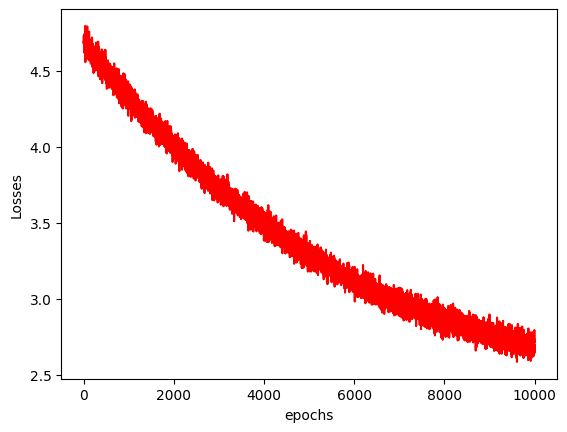

Accuracy: 23.0078125%


oth suffe.
T:$:Ad&x
BR:Pusrer yonxethwans, cAO:
S:
ASav&Syoanignmmo COM,? gimZAroth rimelJ therrthl h.lMhe:ad s feER?


KPhf s,RTh ho at$;ZAExJpay le headG;y;
TEYe l
FDZUK:
The mas?,ulol e pJbyo thornUSC$lsz,
IAMPor.
BWolJlga$$k,Ulo witul.
WeJwh;;$zHPrad
An, lBU,
c pay;s:
BWkRM v. toforsungToDUEd;dTukisealorve s,u:
: P ve;P33ThKO:nves I:' f y GE timeclypis:
APOLETOchKIUzxesto adohthaL ofoNUveadu SavintardQUSHat .
ojX
FOxPENGrrgoof s.
LINThackche ting hiDOke,xThD VOZ$mealisudsth tcasom pllstBanoong$!th t th;
ThinowhlithinM;
Wse$;
-Banothomwise pi. avenQet f cawoo tk an f nldigdHisQM:

IConobUrcrvy?o vojzueris&s,AR&kRDXRIF&xto thivea tithorit$TE: t, y.
KYches y!:K.
OHN'?:th veathDUCKI' hlsBHo,
F nod gXAN.
Mon Mu cNNCof omJ.
 TEDid p'sayovpthdo ch,u!BRuce ttF-o,Wist$;ft!PrePRD tew!
CorfthamNCONOThennF'?
Towororou pewefopyestKIminoforVzMFFCfxirienourk!
ALZ
JJ-MEgoofaXZA&jpardean AThonKIvicSAe h tF ffl,jll IOu,
verd,eathabapathy,
GHaLI farWmunowlimlQxy

IULErnss h r!

In [ ]:
emb_dim = vocab_size
print(vocab_size, emb_dim)


# Hyperparameters
batch_size = 32
block_size = 16
n_epochs = 10000


# intialize Model, optimizer
model = BigramLanguageModel(vocab_size)
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []

for _ in range(n_epochs):
  X,y = batch_loader(train_data, block_size, batch_size)
  logits, loss = model(X,y)

  optim.zero_grad()
  loss.backward()
  optim.step()
  losses.append(loss.item())

  if _ % n_epochs % 1000 == 0:
    print(f"Epoch {_} loss: {loss.item()}")

plt.plot(range(n_epochs), losses, color='red')
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.show()


# logits = F.softmax(logits, dim=-1)
# #check
# print(logits[0,:].sum())

correct = 0
total = 0
with torch.no_grad():
  for _ in range(10):
    X, y = batch_loader(test_data, T, batch_size)
    logits, loss = model(X,y)
    y = y.view(batch_size * T)
    pred = F.softmax(logits, dim=-1) # by each column
    pred = torch.max(logits,dim=-1).indices # by each column
    correct += (pred == y).sum().item()
    total += y.size(0)
  print(f'Accuracy: {100 * correct / total}%')

print('\n')
L = 1000
#idx = torch.zeros((1,1), dtype=torch.long)
idx = X[0]
idx = torch.unsqueeze(idx, 0)
for _ in range(L):
  logits, loss = model(idx)
  logits = logits[:, -1, :] # last character in sequence
  probs = F.softmax(logits, dim=-1)
  idx_next = torch.multinomial(probs, num_samples=1)
  idx = torch.cat((idx, idx_next), dim = 1)

print(decode(idx[0].tolist()))

### Weight aggregation



In [ ]:
# Example of Weighted aggregation for information transferring
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, 1, keepdim=True)
print(a)
b = torch.randint(0, 10, (3,2)).float()
print(b)
c = a @ b
print(c)

B,T,C = 4,5,2 # Batch, Sequence(Time), and Channel (vocab size)
X = torch.randn(B,T,C)
# We want x[b,t] = average of current + prev
# Now each words are having connection
x_1 = torch.zeros((B,T,C))
for b in range(B):
  for t in range(T):
    xprev = X[b, : t+1, :]
    x_1[b,t] = torch.mean(xprev, 0)

# There's more efficient way for weight aggregation: Matrix multiplication
W = torch.tril(torch.ones(T,T))
W = W / W.sum(1, keepdim = True)
x_2 = W @ X
print(torch.allclose(x_1, x_2))

# using Softmax is more efficient
tril = torch.tril(torch.ones(T,T))
W = torch.tril(torch.ones(T,T))
W = W.masked_fill(tril == 0, float('-inf'))
W = F.softmax(W, dim=-1)
x_3 = W @ X
print(torch.allclose(x_1, x_3))

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[4., 3.],
        [3., 7.],
        [8., 3.]])
tensor([[4.0000, 3.0000],
        [3.5000, 5.0000],
        [5.0000, 4.3333]])
True
True


### Simple LLM with token Embedding + position Embedding + Linear

- Token Embedding: for embedded characters
- Position Embedding: embedded position of character
- Linear: embedded space to vocab space

In [ ]:

class demoLanguageModel(nn.Module):

  def __init__(self, emb_dim):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, emb_dim)
    self.pos_embedding = nn.Embedding(block_size, emb_dim)
    self.head = nn.Linear(emb_dim, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape

    tokens = self.token_embedding(idx) # torch.size([batch_size, block_size, emb_dim])
    pos = self.pos_embedding(torch.arange(T)) #torch.size([block_size, emb_dim])

    x = tokens + pos # torch.size([batch_size, block_size, emb_dim])
    logits = self.head(x) # torch.size([batch_size, block_size, vocab_size])

    if targets is None:
      loss = None
    else:
      # B: Batch size
      # T: Block size
      # C: vocab_size
      B,T,C = logits.shape
      logits = logits.view(B*T, C) # B,T,C -> B*T,C ex) size([4,8,65]) -> size([32, 65])
      targets = targets.view(B*T) # B,T -> B*T ex) size([4,8]) -> size([32])
      loss = F.cross_entropy(logits, targets) # cross_entropy(size([32,65], size([32])))
    return logits, loss


## Train & Generate

Epoch 0 loss: 4.408376693725586
Epoch 1000 loss: 2.7924368381500244
Epoch 2000 loss: 2.690809726715088
Epoch 3000 loss: 2.482050895690918
Epoch 4000 loss: 2.5707287788391113


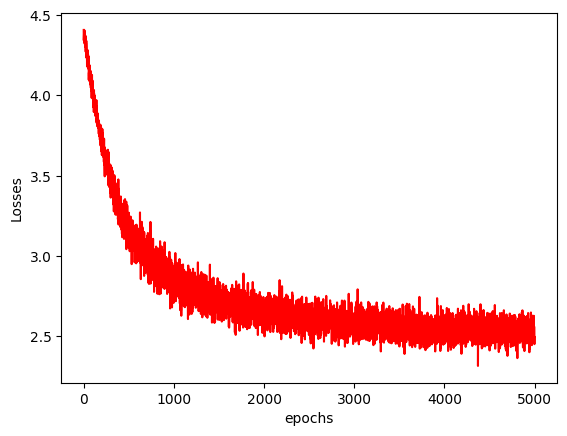

Accuracy: 25.9375%


reford ke bo ke ourad hale abarstpanllle
Bad h ht send t? f Wouke peeon,
SSayO:
I yutothe h r pe mfour, yu, adimear've hayou? thil mars waind MUCidily
COMareak!


Mye?DNI a, be ike ty.
CUKELARI anelemin glow whoerithe idjt whe t fs athihemel.
Houre k is us thatitha's hilldasm.

OND:
Sin at omevond mecay S:
Pu hemanto mitocen this anor ESe pulore my l t athe renlys ERDalat BLKHininafavelo s
Ant nd Is,r Cowancabe ncoury fofond; mous brt n necared piry her m mbe,ll loliutowhy m l matn, me athesis!


Fent aw.

Martlreande CD'be!
Sy,
LUSIoll beloronove perco ee, d merourersulor sarsh Cthandrmeabe?our be Whinced.

 verel heanomeng I n, themerd, cor fuvar y wis o nok CESUSEn,
Hy,

GourJIonfy tid merurt Jingaetusony he,
AS:
Asther t w themet w,
Ashe.
Wte m o t y!
Wisio PE:
He Mescurrcufs ucy m:
APronetidul hellof yomeme veratou hanst le mlle Yo LENG
DENereleabuthe be, f t.
P

YOyothetistoisp,
Dbioo
Ofar? cheweer iknen giothot yilat istho one h'lonorouf talo, ik r atenethee

In [ ]:
# Hyperparameters
batch_size = 32
block_size = 16
n_epochs = 5000
emb_dim = 32 # suggestion from github

# intialize Model, optimizer
model = demoLanguageModel(emb_dim)
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []

for _ in range(n_epochs):
  X,y = batch_loader(train_data, block_size, batch_size)
  logits, loss = model(X,y)

  optim.zero_grad()
  loss.backward()
  optim.step()
  losses.append(loss.item())

  if _ % n_epochs % 1000 == 0:
    print(f"Epoch {_} loss: {loss.item()}")

plt.plot(range(n_epochs), losses, color='red')
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.show()


# logits = F.softmax(logits, dim=-1)
# #check
# print(logits[0,:].sum())

correct = 0
total = 0
with torch.no_grad():
  for _ in range(10):
    X, y = batch_loader(test_data, T, batch_size)
    logits, loss = model(X,y)
    y = y.view(batch_size * T)
    pred = F.softmax(logits, dim=-1) # by each column
    pred = torch.max(logits,dim=-1).indices # by each column
    correct += (pred == y).sum().item()
    total += y.size(0)
  print(f'Accuracy: {100 * correct / total}%')

print('\n')
# Generating
L = 1000
idx = X[0]
idx = torch.unsqueeze(idx, 0)

for _ in range(L):
  idx_cond = idx[:, -block_size:]
  logits, loss = model(idx_cond)
  logits = logits[:, -1, :] # last character in sequence
  probs = F.softmax(logits, dim=-1)
  idx_next = torch.multinomial(probs, num_samples=1)
  idx = torch.cat((idx, idx_next), dim = 1)

print(decode(idx[0].tolist()))

### Self Attention

In [ ]:
B,T,C = batch_size, block_size, emb_dim
# Embedding size: embed each character into its embedding size (1 -> 65)
print(f"Batch: {B}, Block: {T}, Embedding size: {C}")
X = torch.randn(B,T,C)

# Single head
H_size = 20
key = nn.Linear(C, H_size, bias=False)
query = nn.Linear(C, H_size, bias=False)
value = nn.Linear(C, H_size, bias=False)
K = key(X)
Q = query(X)
W = Q @ K.transpose(-2, -1) # (B, T, H) @ (B, H, T) = (B, T, T)

tril = torch.tril(torch.ones(T,T))
W = W.masked_fill(tril == 0, float('-inf'))
W = F.softmax(W, dim=-1)
V = value(X)

res = W @ V
res.shape


Batch: 32, Block: 16, Embedding size: 32


torch.Size([32, 16, 20])

### Head class

In [6]:
class Head(nn.Module):

  def __init__(self, emb_dim, H_size, dropout = 0.2):
    super().__init__()
    self.key = nn.Linear(emb_dim, H_size, bias=False)
    self.query = nn.Linear(emb_dim, H_size, bias=False)
    self.value = nn.Linear(emb_dim, H_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)


  def forward(self, X):
    B,T,C = X.shape
    # B: Batch size
    # T: Block size
    # C: Embedding size
    K = self.key(X) # Size: B,T,H_size
    Q = self.query(X) # Size: B,T,H_Size

    # Compute attention
    W = Q @ K.transpose(-2, -1) # Size: B,T,T
    # Scaled Dot-Product Attention: Control the variance (prevent softmax to be sharpen)
    W = W * C**-0.5
    W = W.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
    W = F.softmax(W, dim=-1)
    W = self.dropout(W) # Dropout randomly shuts off some subset of neurons

    V = self.value(X) # Size: B,T,H_Size
    out = W @ V #Size: B,T,H_Size
    return out





### Language model with one head

In [10]:

class head_LanguageModel(nn.Module):

  def __init__(self, emb_dim):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, emb_dim)
    self.pos_embedding = nn.Embedding(block_size, emb_dim)
    self.attention_head = Head(H_size = emb_dim, emb_dim = emb_dim)
    self.linear_head = nn.Linear(emb_dim, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape

    tokens = self.token_embedding(idx) # torch.size([batch_size, block_size, emb_dim])
    pos = self.pos_embedding(torch.arange(T, device=device)) #torch.size([block_size, emb_dim])

    x = tokens + pos # torch.size([batch_size, block_size, emb_dim])
    x = self.attention_head(x) # torch.size([batch_size, block_size, H_size])
    logits = self.linear_head(x) # torch.size([batch_size, block_Size, vocab_size])

    if targets is None:
      loss = None
    else:
      # B: Batch size
      # T: Block size
      # C: vocab_size
      B,T,C = logits.shape
      logits = logits.view(B*T, C) # B,T,C -> B*T,C ex) size([4,8,65]) -> size([32, 65])
      targets = targets.view(B*T) # B,T -> B*T ex) size([4,8]) -> size([32])
      loss = F.cross_entropy(logits, targets) # cross_entropy(size([32,65], size([32])))
    return logits, loss


## Train & Generate

Epoch 0 loss: 4.145055294036865
Epoch 1000 loss: 2.9231467247009277
Epoch 2000 loss: 2.901885986328125
Epoch 3000 loss: 2.766648292541504
Epoch 4000 loss: 2.6637990474700928


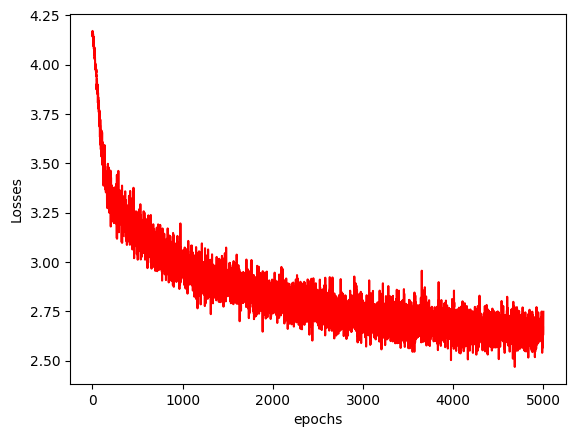

Accuracy: 25.5078125%


Lucentio;
is
Uc buvkrt sihuieyemepin ouk sr te Gary as?
OCnblovo r I s GR:
RDUYI wiLUCKUSSEDr: ouufed me aven silde Sdmohe ny
Wer he LERBOHBy fsrof.
head faw.-
Wyo nos ndf balee Wlod y, ald mevantiter bls ok te.

Sm, ndu Je-y W!Hhsot an hepvaveogihyofe
A me
OI pnesd; tt ertey w;
onecve?
K hu df whithaf! aperre higim ste,,
Ier.
IA:Rnm

Ch'NCy:
ALOLUIE SAHTENECCbmt: hacen, ar gand bin
Hbot.

Iuslu,
zluc 
S il ler.'
Wheen,apsr, Sess w h?

Barirc'youn risrofole a o tyrimy?
W, ing we;wem Aneand, te: mut ver-h the laarey rt: fipefo f tlocer;?

- e ursot d: fh icoungenerq

ru ce hPlilldaen!QAnw than,
!
Bas I
AY vabyh:
Bw o wdhouly he o tsles,
LUCSow fe kame alye ben krin.

Tufeal ert, w by band-benoyar, ia, ke kay hd.

NUTEBl wiopona uun, y, spesoniwh aricde!

PL osuk

OC
ODharinndurkee ng.
un ctheanor K
Sirm h a hclada?

und Wowius gearrourousy, c, r rd Iqwo I fo ths
Mithrir noueur vyer, he it oun.

D,
Sfcy at, wh w. IY utr-Qhafuf Yuldace fresy ber s; e.

S:H: tue tli

In [11]:
# Hyperparameters
batch_size = 32
block_size = 16
n_epochs = 5000
emb_dim = 32 # suggestion from github
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# intialize Model, optimizer
model = head_LanguageModel(emb_dim).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []

for _ in range(n_epochs):
  X,y = batch_loader(train_data, block_size, batch_size)
  X = X.to(device)
  y = y.to(device)
  logits, loss = model(X,y)

  optim.zero_grad()
  loss.backward()
  optim.step()
  losses.append(loss.item())

  if _ % n_epochs % 1000 == 0:
    print(f"Epoch {_} loss: {loss.item()}")

plt.plot(range(n_epochs), losses, color='red')
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.show()


correct = 0
total = 0
with torch.no_grad():
  for _ in range(10):
    X, y = batch_loader(test_data, T, batch_size)
    logits, loss = model(X,y)
    y = y.view(batch_size * T)
    pred = F.softmax(logits, dim=-1) # by each column
    pred = torch.max(logits,dim=-1).indices # by each column
    correct += (pred == y).sum().item()
    total += y.size(0)
  print(f'Accuracy: {100 * correct / total}%')

print('\n')
# Generating
L = 1000
idx = X[0]
idx = torch.unsqueeze(idx, 0)

for _ in range(L):
  idx_cond = idx[:, -block_size:]
  logits, loss = model(idx_cond)
  logits = logits[:, -1, :] # last character in sequence
  probs = F.softmax(logits, dim=-1)
  idx_next = torch.multinomial(probs, num_samples=1)
  idx = torch.cat((idx, idx_next), dim = 1)

print(decode(idx[0].tolist()))

### Multi-Head

- Key concept: Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this. Simply, it's applying multiple attentions in parallel and concatenating the results.

$MultiHead(Q,K,V) = Concat(head_1, ..., head_h)W^O$,

where $head_i = Attention(QW^Q_i, KW^K_i, VW^V_i)$


In [12]:


class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, H_size, emb_dim, dropout = 0.2):
    super().__init__()

    self.heads = nn.ModuleList([Head(emb_dim = emb_dim, H_size = H_size) for _ in range(num_heads)])
    self.proj = nn.Linear(emb_dim, emb_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, X):
    # h(X): size B,T,H_size
    out = torch.cat([h(X) for h in self.heads], dim = -1) #Size : [batch_size, block_size, num_heads * H_size]
    out = self.dropout(self.proj(out))
    return out


In [13]:

class multihead_LanguageModel(nn.Module):

  def __init__(self, emb_dim, num_heads):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, emb_dim)
    self.pos_embedding = nn.Embedding(block_size, emb_dim)
    self.multi_head = MultiHeadAttention(num_heads = num_heads, H_size = emb_dim // num_heads, emb_dim = emb_dim)
    self.linear_head = nn.Linear(emb_dim, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape

    tokens = self.token_embedding(idx) # torch.size([batch_size, block_size, emb_dim])
    pos = self.pos_embedding(torch.arange(T, device=device)) #torch.size([block_size, emb_dim])

    x = tokens + pos # torch.size([batch_size, block_size, emb_dim])
    x = self.multi_head(x) # torch.size([batch_size, block_size, H_size])
    logits = self.linear_head(x) # torch.size([batch_size, block_Size, vocab_size])

    if targets is None:
      loss = None
    else:
      # B: Batch size
      # T: Block size
      # C: vocab_size
      B,T,C = logits.shape
      logits = logits.view(B*T, C) # B,T,C -> B*T,C ex) size([4,8,65]) -> size([32, 65])
      targets = targets.view(B*T) # B,T -> B*T ex) size([4,8]) -> size([32])
      loss = F.cross_entropy(logits, targets) # cross_entropy(size([32,65], size([32])))
    return logits, loss


### Multihead Language Model Train & Generate

Epoch 0 loss: 4.201522350311279
Epoch 1000 loss: 2.8105628490448
Epoch 2000 loss: 2.6902754306793213
Epoch 3000 loss: 2.591181755065918
Epoch 4000 loss: 2.4952852725982666


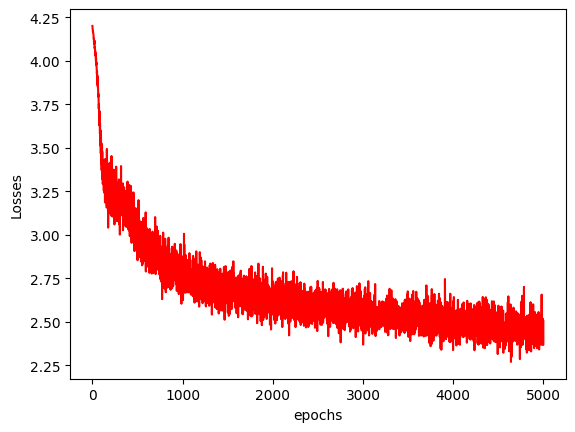

Accuracy: 29.04296875%


 patience she with her:
ploro s phoutgdh, inen
Fomhe,, rend-be youpnts?
I
Bbur vaal the sranofl oupone ut puze hir tult iiw,
We a'my brelldfullets! oou ouwu
TCa athe reamid s
Gt lowtd fhi'sd ow ald,souche an rarib?
tre
RBHe percfirabl.

Kcicenter dis thu possufi?
Bvekde auglt how or Moflat hu orsd opiw' dusege asouvsan iled my tis lou,
kiw thowwate.
Hy
PRAD:
GCIHEEKiREGr!
DR::
I thoive the tye-nise weis.

Tho Aged humrote wham aratave Imegelive Ias ts.
uydhy o I:
TI ou I csithely isfy ee, e bas candndealicouv,
Oant Pgellory otenth his pote uemxatrerlim, ans, ussshot the hlolow laam; atwiw hyes.
Hescar Maw kavisthls br le
hre,
P I o Bn:
At
ODe:ot mar.
RA Dfas Whinp dodspe gue W:
Tow orowthan tor lour, tends ebbp watouch terely.

Seergame Fids: oriromk mesaltt,
P: he Whe, wear, nves? ouudecsas t Wibrene whe thip'pyag oy eane, s jpon:
Mindllof, Vihe omd Wha hugud whos lom sanyou, ofut che olle;
Anes wa at myeeves po sondd,ha itd, inos a thoctilenfe oul, oons, ry.


In [ ]:
# Hyperparameters
batch_size = 32
block_size = 16
n_epochs = 5000
emb_dim = 32 # suggestion from github
num_heads = 4

# intialize Model, optimizer
model = multihead_LanguageModel(emb_dim, num_heads = num_heads)
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []

for _ in range(n_epochs):
  X,y = batch_loader(train_data, block_size, batch_size)
  logits, loss = model(X,y)

  optim.zero_grad()
  loss.backward()
  optim.step()
  losses.append(loss.item())

  if _ % n_epochs % 1000 == 0:
    print(f"Epoch {_} loss: {loss.item()}")

plt.plot(range(n_epochs), losses, color='red')
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.show()


correct = 0
total = 0
with torch.no_grad():
  for _ in range(10):
    X, y = batch_loader(test_data, T, batch_size)
    logits, loss = model(X,y)
    y = y.view(batch_size * T)
    pred = F.softmax(logits, dim=-1) # by each column
    pred = torch.max(logits,dim=-1).indices # by each column
    correct += (pred == y).sum().item()
    total += y.size(0)
  print(f'Accuracy: {100 * correct / total}%')

print('\n')
# Generating
L = 1000
idx = X[0]
idx = torch.unsqueeze(idx, 0)

for _ in range(L):
  idx_cond = idx[:, -block_size:]
  logits, loss = model(idx_cond)
  logits = logits[:, -1, :] # last character in sequence
  probs = F.softmax(logits, dim=-1)
  idx_next = torch.multinomial(probs, num_samples=1)
  idx = torch.cat((idx, idx_next), dim = 1)

print(decode(idx[0].tolist()))

### Feed Forward

- Feed forward part is a simple MLP.

In [14]:
class FeedForward(nn.Module):
  def __init__(self, num_embd, dropout= 0.2):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(num_embd, 4 * num_embd),
        nn.ReLU(),
        nn.Linear(4 * num_embd, num_embd), # Projection layer
        nn.Dropout(dropout)
    )
  def forward(self, X):
    return self.net(X)


### Block

In [15]:

# class MultiHeadAttention(nn.Module):
#   def __init__(self, num_heads, H_size, emb_dim, dropout = 0.0):
#     super().__init__()

class Block(nn.Module):
  def __init__(self, emb_dim, num_heads):
    super().__init__()
    H_size = emb_dim // num_heads

    self.multihead = MultiHeadAttention(num_heads = num_heads, H_size=H_size, emb_dim = emb_dim)
    self.ff = FeedForward(emb_dim)
    self.ln1 = nn.LayerNorm(emb_dim)
    self.ln2 = nn.LayerNorm(emb_dim)

  def forward(self, X):
    # Residual connection
    X = X + self.multihead(self.ln1(X))
    X = X + self.ff(self.ln2(X))
    return X



# Transformer

In [16]:
# Simple Transformer
class Transformer(nn.Module):

  def __init__(self, emb_dim, num_heads, n_layer):
    super().__init__()
    self.token_embedding = nn.Embedding(vocab_size, emb_dim)
    self.pos_embedding = nn.Embedding(block_size, emb_dim)

    self.blocks = nn.Sequential(*[Block(emb_dim, num_heads) for _ in range(n_layer)])
    self.norm = nn.LayerNorm(emb_dim)
    self.linear_head = nn.Linear(emb_dim, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape

    tokens = self.token_embedding(idx) # torch.size([batch_size, block_size, emb_dim])
    pos = self.pos_embedding(torch.arange(T, device=device)) #torch.size([block_size, emb_dim])

    x = tokens + pos # torch.size([batch_size, block_size, emb_dim])
    x = self.blocks(x) # torch.size([batch_size, block_size, H_size])
    x = self.norm(x)
    logits = self.linear_head(x) # torch.size([batch_size, block_Size, vocab_size])

    if targets is None:
      loss = None
    else:
      # B: Batch size
      # T: Block size
      # C: vocab_size
      B,T,C = logits.shape
      logits = logits.view(B*T, C) # B,T,C -> B*T,C ex) size([4,8,65]) -> size([32, 65])
      targets = targets.view(B*T) # B,T -> B*T ex) size([4,8]) -> size([32])
      loss = F.cross_entropy(logits, targets) # cross_entropy(size([32,65], size([32])))
    return logits, loss


In [20]:
for _ in range(n_epochs):
  if _ % n_epochs % 1000 == 0 or _ == n_epochs-1:
    print(_)

0
1000
2000
3000
4000
4999


Epoch 0 loss: 4.28328800201416
Epoch 1000 loss: 1.675100564956665
Epoch 2000 loss: 1.4356682300567627
Epoch 3000 loss: 1.3243190050125122
Epoch 4000 loss: 1.1923257112503052
Epoch 4999 loss: 1.1533812284469604


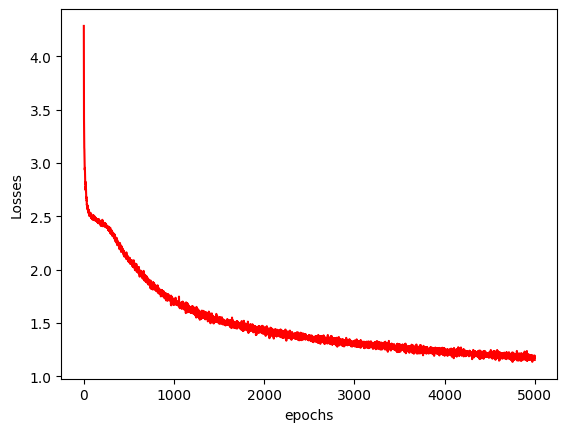

Accuracy: 44.765625%


d wherefore my love I should said,
In hopes all my accusationary.
Could I slip his corse to bed me as flaces
I cannot one at, I objury to King Leord lost.

DUKE VINCENTIO:
The meplumite of putting throne my house,
And bid us reway to be well less.
Hadst thee already it fast a bereaty;
And hence hath not lengthen lame his soul sight:
An I am heard off guardfully fears,
Drop thing neighbours, his son, mar.

ANOd MOWARD:
Whither of our fairly laws he takes his blessess'd!
Unsay the third form the truth of guills
And which or after we heard' front,
And as it is fortune.
Of what, O, you had prome adversar hither!
This moor, I'll ream him better when my
To breathe will fond and joys; mult not, so who,
That I would know within a husband spirit,
And that named the power of your sea usurping majest
Lest him that you do a sleeper.

THOMAS MOTRANSIO:
All think
Rememberse his blacks. Thus 'I can your sovereign
Our states but this is King Leontes;
He thinks the cite the nough

In [21]:
# Hyperparameters
batch_size = 64
block_size = 256
n_epochs = 5000
emb_dim = 384
num_heads = 6
n_layer = 6
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# intialize Model, optimizer
model = Transformer(emb_dim, num_heads, n_layer).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []

for _ in range(n_epochs):
  X,y = batch_loader(train_data, block_size, batch_size)
  logits, loss = model(X,y)

  optim.zero_grad()
  loss.backward()
  optim.step()
  losses.append(loss.item())

  if _ % n_epochs % 1000 == 0 or _ == n_epochs-1:
    print(f"Epoch {_} loss: {loss.item()}")

plt.plot(range(n_epochs), losses, color='red')
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.show()


correct = 0
total = 0
with torch.no_grad():
  for _ in range(10):
    X, y = batch_loader(test_data, T, batch_size)
    logits, loss = model(X,y)
    y = y.view(batch_size * T)
    pred = F.softmax(logits, dim=-1) # by each column
    pred = torch.max(logits,dim=-1).indices # by each column
    correct += (pred == y).sum().item()
    total += y.size(0)
  print(f'Accuracy: {100 * correct / total}%')

print('\n')
# Generating
L = 1000
idx = X[0]
idx = torch.unsqueeze(idx, 0)

for _ in range(L):
  idx_cond = idx[:, -block_size:]
  logits, loss = model(idx_cond)
  logits = logits[:, -1, :] # last character in sequence
  probs = F.softmax(logits, dim=-1)
  idx_next = torch.multinomial(probs, num_samples=1)
  idx = torch.cat((idx, idx_next), dim = 1)

print(decode(idx[0].tolist()))

In [22]:
import pathlib
saved_params_path = "./saved_params_base_llm"
pathlib.Path(f"./{saved_params_path}/").mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), f'{saved_params_path}/base_transformer_llm.pth')

generated_txt = open('generated_shakespeare.txt', 'w')
generated_txt.write(decode(idx[0].tolist()))
generated_txt.close()